# Automatic Differentiation Implementation

In this notebook, we will implement **Forward Mode** and **Reverse Mode** from **Automatic Differentiation** using the operator overloading method in Python. The core idea is to define a custom `Variable` class that keeps track of both the value and its derivative and overloads arithmetic operations to propagate derivatives according to calculus rules.


# Forward Mode

## The `VariableForward` Class

The `VariableForward` class in forward mode automatic differentiation represents a value during computation along with its **tangent**, which is the derivative of the function with respect to that VariableForward.

It encapsulates two key components:
- **`primal`**: the actual numerical value of the VariableForward (used to evaluate the function normally)
- **`tangent`**: the value of the derivative of the output with respect to this VariableForward (used to track how a small change in the input affects the output)

In forward mode, we compute both the value and derivative **simultaneously** as we evaluate the function. This is particularly efficient when the number of inputs is small compared to the number of outputs.

### Operator Overloading

We override the standard arithmetic operations (`+`, `-`, `*`, `/`) to support automatic propagation of derivatives. Each operation not only computes the result of the operation but also applies the **chain rule** to update the tangent accordingly.

For instance, if `x` and `y` are `VariableForward` objects:
- `x * y` will compute:
  - `primal = x.primal * y.primal`
  - `tangent = x.tangent * y.primal + y.tangent * x.primal`

We also support operations between a `VariableForward` and a plain Python number, making it seamless to mix constants and variables in expressions.

### Elementary Functions

Functions like `sin`, `exp`, and `square` are defined specifically for `VariableForward` inputs. They compute both:
- the function value (e.g. `sin(x.primal)`)
- the derivative using the chain rule (e.g. `cos(x.primal) * x.tangent` for `sin(x)`)

This setup allows us to compute the derivative of any scalar function programmatically, just by initializing the input variables with appropriate tangent values (typically `1.0` for the VariableForward of interest and `0.0` for others).

Forward mode is ideal when you're interested in how a function changes with respect to **one** input at a time, such as computing directional derivatives or columns of the Jacobian matrix.


In [ ]:
import numpy as np
import math
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [20]:
class VariableForward:
    def __init__(self, primal, tangent=0.0):
        self.primal = primal
        self.tangent = tangent

    def __add__(self, other):
        if isinstance(other, VariableForward):
            return VariableForward(self.primal + other.primal, self.tangent + other.tangent)
        else:
            return VariableForward(self.primal + other, self.tangent)

    def __sub__(self, other):
        if isinstance(other, VariableForward):
            return VariableForward(self.primal - other.primal, self.tangent - other.tangent)
        else:
            return VariableForward(self.primal - other, self.tangent)
    
    def __mul__(self, other):
        if isinstance(other, VariableForward):
            return VariableForward(
                self.primal * other.primal,
                self.tangent * other.primal + other.tangent * self.primal
            )
        else:
            return VariableForward(self.primal * other, self.tangent * other)

    def __truediv__(self, other):
        return VariableForward(
            self.primal / other.primal,
            (self.tangent * other.primal - self.primal * other.tangent) / (other.primal**2)
        )
    
    def __radd__(self, other):
        return self + other if isinstance(other, VariableForward) else VariableForward(self.primal + other, self.tangent)

    def __rmul__(self, other):
        return self * other if isinstance(other, VariableForward) else VariableForward(self.primal * other, self.tangent * other)


    def __repr__(self):
        return f"primal: {self.primal:.3f}, tangent: {self.tangent:.3f}"
        

def sin(x):
    return VariableForward(math.sin(x.primal), math.cos(x.primal) * x.tangent)

def exp(x):
    epx = math.exp(x.primal)
    return VariableForward(epx, epx * x.tangent)

def square(x):
    return VariableForward(x.primal**2, 2 * x.primal * x.tangent)

## Example 1: Automatic differentiation in forward mode

Let's calculate the partial derivatives of the function

$$f(x_1, x_2) = \left[\sin\left(\frac{x_1}{x_2}\right) + \frac{x_1}{x_2} - e^{x_2}\right] \cdot \left[\frac{x_1}{x_2} - e^{x_2}\right]$$

using forward mode, at the point $ (x_1, x_2) = (1.5, 0.5) $.



In [30]:
def f(x1, x2):
    return (sin(x1 / x2) + x1 / x2 - exp(x2)) * (x1 / x2 - exp(x2))

### Calculation of $ \frac{\partial f}{\partial x_1} $ at (1.5, 0.5)

In [31]:
x1_val = 1.5
x1_tan = 1.0
x2_val = 0.5
x2_tan = 0.0

x1 = VariableForward(x1_val, x1_tan)  # ∂x1/∂x1 = 1
x2 = VariableForward(x2_val, x2_tan)  # ∂x2/∂x1 = 0

y = f(x1, x2)
print(f"f({x1_val:.1f}, {x2_val:.1f}) = {y.primal:.3f}")
print(f"∂f/∂x1 = {y.tangent:.3f}")

f(1.5, 0.5) = 2.017
∂f/∂x1 = 3.012


### Calculation of $ \frac{\partial f}{\partial x_2} $ at (1.5, 0.5)

In [32]:
x1_val = 1.5
x1_tan = 0.0
x2_val = 0.5
x2_tan = 1.0

x1 = VariableForward(x1_val, x1_tan)  # ∂x1/∂x1 = 0
x2 = VariableForward(x2_val, x2_tan)  # ∂x2/∂x1 = 1

y = f(x1, x2)
print(f"f({x1_val:.1f}, {x2_val:.1f}) = {y.primal:.3f}")
print(f"∂f/∂x2 = {y.tangent:.3f}")


f(1.5, 0.5) = 2.017
∂f/∂x2 = -13.724


## Example 2: Automatic differentiation in forward mode

Let's calculate the Jacobian matrix of the function

$$
g(x_1, x_2, x_3, x_4) = (x_2 \sin(x_1) + x_2^2, 2 \, x_3x_4 + x_1) = (r_0, r_1)
$$

using forward mode, at the point $(x_1, x_2, x_3, x_4) = (1.5, 0.5, 2.0, 3.0)$.

In [33]:
def g(x1, x2, x3, x4):
    r0 = x2 * sin(x1) + square(x2)
    r1 = 2 * x3 * x4 + x1
    return [r0, r1]


In [34]:
def compute_jacobian(f, x_vals):
    n_inputs = len(x_vals)
    y_sample = f(*[VariableForward(val, 0.0) for val in x_vals])
    n_outputs = len(y_sample)
    
    jacobian = []

    for i in range(n_inputs):
        # Set all tangents to 0.0 except for the i-th VariableForward
        x_vars = [VariableForward(val, 1.0 if j == i else 0.0) for j, val in enumerate(x_vals)]
        y = f(*x_vars)
        jacobian.append([yi.tangent for yi in y])
    
    # Print primal output and the Jacobian in aligned format with square brackets
    print(f"g({', '.join(map(str, x_vals))}) =", [yi.primal for yi in y_sample])
    print("\nJ_g:")
    for row in list(map(list, zip(*jacobian))):
        print(f"[{', '.join(f'{val: .3f}' for val in row)}]")

    return jacobian


In [35]:
x_vals = [1.5, 0.5, 2.0, 3.0]
J = compute_jacobian(g, x_vals)

g(1.5, 0.5, 2.0, 3.0) = [0.7487474933020273, 13.5]

J_g:
[ 0.035,  1.997,  0.000,  0.000]
[ 1.000,  0.000,  6.000,  4.000]


## Example 3: Benchmarking Forward-Mode Automatic Differentiation

We are analyzing a vector-valued function defined as follows:

$$
y[j] = \sum_{i=0}^{n-1} (x[i] \cdot (j + 1)) \quad \text{for } j = 0 \text{ to } m-1
$$


So the output vector consists of scaled sums of all inputs, with each output scaled by its own index. 

We want to **measure and compare** the **execution time** needed to compute the full Jacobian of the function getting three distinct scenarios:

### 1. Varying Input Size (n)
- The number of outputs `m` is kept fixed (e.g., `m = 100`)
- The number of inputs `n` increases
- **Purpose:** To see how performance scales as input dimensionality increases

### 2. Varying Output Size (m)
- The number of inputs `n` is kept fixed (e.g., `n = 100`)
- The number of outputs `m` increases
- **Purpose:** To observe time changes as the number of output equations grows

### 3. Square Case (n = m)
- Both inputs and outputs are increased together
- **Purpose:** To evaluate the performance when the squared Jacobian is incremented

---

### What We Expect to See

- **Forward-mode automatic differentiation** scales **linearly with the number of inputs** (`n`) because it computes one directional derivative at a time.
- Increasing the number of **outputs** (`m`) will impact performance, but typically not as severely, since outputs are all computed in one forward pass.
- In the **square case** (`n = m`), we expect the time complexity to grow **quadratically**, due to the interplay of increasing both dimensions.

Running benchmarks for size=10...
  Vary n: 0.0180s, Vary m: 0.0987s, Square: 0.0010s
Running benchmarks for size=20...
  Vary n: 0.0389s, Vary m: 0.1955s, Square: 0.0080s
Running benchmarks for size=30...
  Vary n: 0.0828s, Vary m: 0.3047s, Square: 0.0269s
Running benchmarks for size=40...
  Vary n: 0.1426s, Vary m: 0.4144s, Square: 0.0668s
Running benchmarks for size=50...
  Vary n: 0.2305s, Vary m: 0.6029s, Square: 0.1167s
Running benchmarks for size=60...
  Vary n: 0.3426s, Vary m: 0.5935s, Square: 0.1915s
Running benchmarks for size=70...
  Vary n: 0.5067s, Vary m: 0.7491s, Square: 0.3611s
Running benchmarks for size=80...
  Vary n: 0.5994s, Vary m: 0.7261s, Square: 0.4857s
Running benchmarks for size=90...
  Vary n: 0.7690s, Vary m: 0.8538s, Square: 0.6972s
Running benchmarks for size=100...
  Vary n: 1.0134s, Vary m: 0.9839s, Square: 0.9650s
Running benchmarks for size=110...
  Vary n: 1.1410s, Vary m: 1.0657s, Square: 1.3086s
Running benchmarks for size=120...
  Vary n: 1.3585s

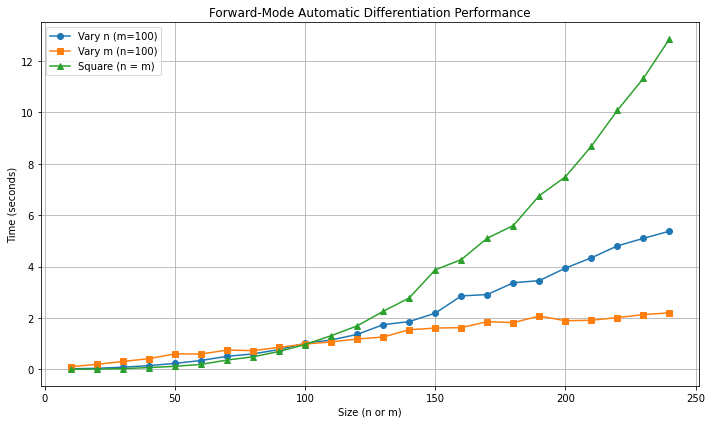

In [21]:
def vector_func(n, m):
    # Let's say x is length n, we return m outputs
    return [sum(xi * (j + 1) for xi in n) for j in range(m)]

def compute_jacobian_vector(f, x_vals, m):
    n_inputs = len(x_vals)    
    jacobian = []

    for i in range(n_inputs):
        # Set all tangents to 0.0 except for the i-th variable
        x_vars = [VariableForward(val, 1.0 if j == i else 0.0) for j, val in enumerate(x_vals)]
        y = f(x_vars, m)
        jacobian.append([yi.tangent for yi in y])

    return jacobian

# Wrapper for benchmarking
def compute_jacobian(n, m):
    x_vals = np.random.rand(n).tolist()  # Random input vector of size n
    start_time = time.time()
    jacobian = compute_jacobian_vector(vector_func, x_vals, m)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time, jacobian

# Benchmarking loop
sizes = list(range(10, 250, 10))  
fixed_m = 100
fixed_n = 100

times_vary_n_forward = []
times_vary_m_forward = []
times_square_forward = []

for i in sizes:
    print(f"Running benchmarks for size={i}...")

    # 1. Vary n, fix m
    t1, _ = compute_jacobian(i, fixed_m)
    times_vary_n_forward.append(t1)

    # 2. Vary m, fix n
    t2, _ = compute_jacobian(fixed_n, i)
    times_vary_m_forward.append(t2)

    # 3. Square case (n = m)
    t3, _ = compute_jacobian(i, i)
    times_square_forward.append(t3)

    print(f"  Vary n: {t1:.4f}s, Vary m: {t2:.4f}s, Square: {t3:.4f}s")

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(sizes, times_vary_n_forward, label=f"Vary n (m={fixed_m})", marker='o')
plt.plot(sizes, times_vary_m_forward, label=f"Vary m (n={fixed_n})", marker='s')
plt.plot(sizes, times_square_forward, label="Square (n = m)", marker='^')
plt.title("Forward-Mode Automatic Differentiation Performance")
plt.xlabel("Size (n or m)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Example 4: Benchmarking BAM Energy Function with Forward-Mode Automatic Differentiation

## Background: Bidirectional Associative Memory (BAM)

Bidirectional Associative Memory (BAM) is a type of **recurrent neural network** that models associative memory using **two layers of neurons**:

- A **first layer** with `K` units (input layer)
- A **second layer** with `J` units (output layer)

Each unit in the first layer is **bidirectionally connected** to each unit in the second layer. The synaptic connection between unit `k` in the first layer and unit `j` in the second layer has a weight denoted by `wₖⱼ`.

### Network Dynamics

The BAM network updates the state of all units in one layer at a time, alternating between layers until it converges to a **stable state** (an attractor). The state update rules are based on whether the weighted sum of inputs exceeds a **threshold**:

$$
x_k(i + 1) = \text{sign}\left( \sum_{j} w_{kj} y_j(i) - \theta_k \right)
$$

For the second layer (J units):
$$
y_j(i + 1) = \text{sign}\left( \sum_{k} w_{kj} x_k(i) - \eta_j \right)
$$

Where:
- `xₖ`, `yⱼ` are the binary states (-1 or 1) of the units
- `θₖ`, `ηⱼ` are the bias thresholds

---

## BAM Energy Function

To understand the stability and convergence of the BAM network, we define an **energy function**:

$$
E = - \sum_{j=1}^{J} \sum_{k=1}^{K} w_{kj} x_k y_j + \sum_{k=1}^{K} \theta_k x_k + \sum_{j=1}^{J} \eta_j y_j
$$


This scalar function measures the “energy” of the current network state, and it **decreases over time** as the network evolves, guaranteeing convergence to a local minimum.

---

## Goal of the Benchmark

We aim to **measure the performance** of **forward-mode automatic differentiation**. Since the BAM energy function depends on two sets of variables — the first layer $ x = (x_1, \dots, x_K) $ and the second layer $ y = (y_1, \dots, y_J) $— we can think of the inputs as a **single concatenated vector**:

$$
\text{inputs} = (x_1, \dots, x_K, y_1, \dots, y_J) \quad \in \quad \mathbb{R}^{K+J}
$$

The **Jacobian** of $E$ with respect to these inputs is a **row vector**:

$$
\text{Jacobian} = \left[
\frac{\partial E}{\partial x_1}, \dots, \frac{\partial E}{\partial x_K}, 
\frac{\partial E}{\partial y_1}, \dots, \frac{\partial E}{\partial y_J}
\right]
\quad \in \quad \mathbb{R}^{1 \times (K+J)}
$$

where each entry represents the sensitivity of the energy function to a small change in one input variable.

For increasing network sizes (larger values of $n$), we benchmark:

- **Time taken** to compute the energy value $E(x, y)$
- **Time taken** to compute the **full gradient** (Jacobian) of $E$ with respect to all input variables
- **How performance scales** (in terms of time and computational complexity) as the problem size increases

n=10, Time=0.00100s, Energy=6.163, Gradient dE/dx = ['1.791', '0.644', '1.423', '0.606', '0.011'],  Gradient dE/dy = ['-0.930', '0.677', '-1.072', '0.097', '0.305']
n=30, Time=0.01097s, Energy=-6.656, Gradient dE/dx = ['-1.489', '-1.704', '1.489', '3.799', '-2.430', '3.488', '4.276', '-0.722', '1.349', '-3.985', '5.482', '-1.726', '-0.920', '2.513', '2.645'],  Gradient dE/dy = ['-1.800', '2.421', '-0.645', '-1.579', '4.408', '-5.713', '0.883', '3.419', '2.493', '-2.021', '-3.336', '3.792', '1.076', '4.086', '2.814']
n=50, Time=0.05386s, Energy=-0.584, Gradient dE/dx = ['-3.137', '1.644', '-0.019', '3.091', '0.301', '-1.098', '1.826', '-6.705', '-2.937', '-1.277', '4.172', '2.587', '5.239', '-4.004', '0.651', '-0.554', '0.147', '-0.041', '3.123', '4.712', '2.223', '0.623', '0.957', '-2.449', '0.570'],  Gradient dE/dy = ['0.801', '-5.562', '-2.903', '-2.315', '1.180', '-0.892', '2.510', '-1.788', '-3.765', '-2.386', '2.715', '-3.320', '-0.677', '0.282', '-1.210', '1.367', '2.678', '0.309

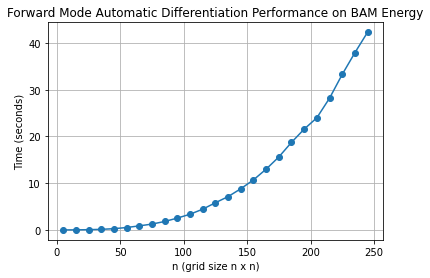

In [38]:
def bam_energy(x, y, W, theta, eta):
    E = VariableForward(0.0, 0.0)
    for j in range(len(y)):
        for k in range(len(x)):
            E += -W[k][j] * x[k] * y[j]
    for k in range(len(x)):
        E += theta[k] * x[k]
    for j in range(len(y)):
        E += eta[j] * y[j]
    return E

def full_gradient_bam(n, W, theta, eta):
    grad = []

    for i in range(2 * n):
        # Build the full input vector: x variables first, then y variables
        input_vars = [
            VariableForward(random.choice([-1.0, 1.0]), 1.0 if j == i else 0.0)
            for j in range(2 * n)
        ]

        # Split input into x and y
        x = input_vars[:n]
        y = input_vars[n:]

        E = bam_energy(x, y, W, theta, eta)
        grad.append(E.tangent)

    return E, grad

def generate_bam_params(n):
    W = [[random.uniform(-1.0, 1.0) for _ in range(n)] for _ in range(n)]
    theta = [random.uniform(-0.5, 0.5) for _ in range(n)]
    eta = [random.uniform(-0.5, 0.5) for _ in range(n)]
    return W, theta, eta

def benchmark_bam_autodiff(n):
    W, theta, eta = generate_bam_params(n)

    start = time.time()
    E, grad = full_gradient_bam(n, W, theta, eta)
    end = time.time()

    return end - start, E.primal, grad[:n], grad[n:]

ns = list(range(5, 255, 10))
times_forward = []

for n in ns:
    t, energy, gradX, gradY = benchmark_bam_autodiff(n) 
    print(f"n={2*n}, Time={t:.5f}s, Energy={energy:.3f}, Gradient dE/dx = {[f'{g:.3f}' for g in gradX]},  Gradient dE/dy = {[f'{g:.3f}' for g in gradY]}")
    times_forward.append(t)

plt.plot(ns, times_forward, marker='o')
plt.title("Forward Mode Automatic Differentiation Performance on BAM Energy")
plt.xlabel("n (grid size n x n)")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

# Reverse Mode

## The `VariableReverse` Class

The `VariableReverse` class in reverse mode automatic differentiation represents a value used during computation and its corresponding **adjoint**, which holds the derivative of a final output with respect to that value.

It encapsulates two key attributes:
- **`primal`**: the actual value of the variable (used during function evaluation)
- **`adjoint`**: the accumulated gradient (derivative of the final result with respect to this variable)

In reverse mode, we evaluate the function **forward** (to compute all intermediate values), and then initiate a **reverse pass** (by calling `.backward()`) from the output back through the computation graph, accumulating derivatives into the `adjoint` of each variable.

Each arithmetic operation constructs a new `VariableReverse` and assigns it a custom `backward()` function, which:
1. Accumulates the incoming gradient into the result variable.
2. Computes the local partial derivatives.
3. Propagates those gradients to the operand variables using their `backward()` methods.

We also define reverse-mode implementations for elementary functions like `sin`, `exp`, and `square`, and include Python operator overloads so expressions like `2 * x` or `x + 3.0` work seamlessly.

This setup allows us to compute gradients of scalar outputs with respect to any number of inputs automatically, just by calling `.backward(1.0)` on the final result.


In [24]:
class VariableReverse:
    def __init__(self, primal, parents=None, grad_fn=None):
        self.primal = primal
        self.adjoint = 0.0
        self.parents = parents if parents is not None else []
        self.grad_fn = grad_fn  # function to propagate adjoint

    def backward(self, adjoint=1.0):
        self.adjoint += adjoint
        stack = [(self, adjoint)]  # Start with self and given adjoint

        while stack:
            var, adjoint = stack.pop()
            var.adjoint += adjoint
            if var.grad_fn is not None:
                grads = var.grad_fn(adjoint)
                for parent, grad in zip(var.parents, grads):
                    stack.append((parent, grad))  # Push onto stack

    def __add__(self, other):
        if not isinstance(other, VariableReverse):
            other = VariableReverse(other)
        out = VariableReverse(self.primal + other.primal, parents=[self, other],
                       grad_fn=lambda adjoint: [adjoint, adjoint])
        return out

    def __sub__(self, other):
        if not isinstance(other, VariableReverse):
            other = VariableReverse(other)
        out = VariableReverse(self.primal - other.primal, parents=[self, other],
                       grad_fn=lambda adjoint: [adjoint, -adjoint])
        return out

    def __mul__(self, other):
        if not isinstance(other, VariableReverse):
            other = VariableReverse(other)
        out = VariableReverse(self.primal * other.primal, parents=[self, other],
                       grad_fn=lambda adjoint: [adjoint * other.primal, adjoint * self.primal])
        return out

    def __truediv__(self, other):
        if not isinstance(other, VariableReverse):
            other = VariableReverse(other)
        out = VariableReverse(self.primal / other.primal, parents=[self, other],
                       grad_fn=lambda adjoint: [adjoint * (1.0 / other.primal),
                                                adjoint * (-self.primal / (other.primal ** 2))])
        return out

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return VariableReverse(other) - self

    def __rmul__(self, other):
        return self * other

    def __rtruediv__(self, other):
        return VariableReverse(other) / self

    def __repr__(self):
        return f"primal: {self.primal:.4f}, adjoint: {self.adjoint:.4f}"

def sin(var):
    out = VariableReverse(math.sin(var.primal), parents=[var],
                   grad_fn=lambda adjoint: [adjoint * math.cos(var.primal)])
    return out

def exp(var):
    out = VariableReverse(math.exp(var.primal))
    out.parents = [var]
    out.grad_fn = lambda adjoint: [adjoint * out.primal]
    return out

def square(var):
    out = VariableReverse(var.primal**2, parents=[var],
                   grad_fn=lambda adjoint: [adjoint * 2 * var.primal])
    return out

## Example 1: Automatic differentiation in reverse mode

Let's calculate the derivative of the function

$$
f(x_1, x_2) = \left[\sin\left(\frac{x_1}{x_2}\right) + \frac{x_1}{x_2} - e^{x_2}\right] \cdot \left[\frac{x_1}{x_2} - e^{x_2}\right]
$$

using forward mode, at the point $ (x_1, x_2) = (1.5, 0.5) $ first with respect to $ x_1 $, and then with respect to $ x_2 $.



In [41]:
def f(x1, x2):
    return (sin(x1 / x2) + x1 / x2 - exp(x2)) * (x1 / x2 - exp(x2))

In [42]:
x1 = VariableReverse(1.5)
x2 = VariableReverse(0.5)

y = f(x1, x2)
y.backward(1.0)

print(f"f({x1.primal:.1f}, {x2.primal:.1f}) = {y.primal:.3f}")
print(f"∂y/∂x1 = {x1.adjoint}")
print(f"∂y/∂x2 = {x2.adjoint}")


f(1.5, 0.5) = 2.017
∂y/∂x1 = 3.011843327673907
∂y/∂x2 = -13.723961509314078


## Example 2: Automatic differentiation in reverse mode

Let's calculate the derivative of the function

$$
g(x_1, x_2, x_3, x_4) = (x_2 \sin(x_1) + x_2^2, 2 \, x_3x_4 + x_1) = (r_0, r_1)
$$

using reverse mode, at the point $(x_1, x_2, x_3, x_4) = (1.5, 0.5, 2.0, 3.0)$. This example will focus on getting the Jacobian matrix.

In [43]:
def g(x1, x2, x3, x4):
    r0 = x2 * sin(x1) + square(x2)
    r1 = 2 * x3 * x4 + x1
    return [r0, r1]

In [44]:
def compute_jacobian_reverse(f, x_vals):
    n_inputs = len(x_vals)

    # Wrap raw inputs as Variables (fresh copies for each reverse pass)
    def make_vars():
        return [VariableReverse(val) for val in x_vals]

    # Forward pass to get outputs and output count
    vars = make_vars()
    outputs = f(*vars)
    n_outputs = len(outputs)

    jacobian = []

    for i in range(n_outputs):
        # Reset adjoints (fresh inputs and outputs every time)
        vars = make_vars()
        outputs = f(*vars)

        # Start reverse pass for output i
        outputs[i].backward(1.0)

        # Collect ∂output_i/∂xj (j = 0 to n_inputs-1)
        jacobian.append([var.adjoint for var in vars])

    # Print formatted Jacobian
    print(f"g({', '.join(map(str, x_vals))}) =", [y.primal for y in outputs])
    print("\nJ_g:")
    for row in jacobian:
        print(f"[{', '.join(f'{val: .3f}' for val in row)}]")

    return jacobian

In [45]:
x_vals = [1.5, 0.5, 2.0, 3.0]
J = compute_jacobian_reverse(g, x_vals)

g(1.5, 0.5, 2.0, 3.0) = [0.7487474933020273, 13.5]

J_g:
[ 0.035,  1.997,  0.000,  0.000]
[ 1.000,  0.000,  6.000,  4.000]


## Example 3: Benchmarking Reverse-Mode Automatic Differentiation

We are analyzing a vector-valued function defined as follows:

$$
y[j] = \sum_{i=0}^{n-1} (x[i] \cdot (j + 1)) \quad \text{for } j = 0 \text{ to } m-1
$$


So the output vector consists of scaled sums of all inputs, with each output scaled by its own index. 

We want to **measure and compare** the **execution time** needed to compute the full Jacobian of the function getting three distinct scenarios:

### 1. Varying Input Size (n)
- The number of outputs `m` is kept fixed (e.g., `m = 100`)
- The number of inputs `n` increases
- **Purpose:** To see how performance scales as input dimensionality increases

### 2. Varying Output Size (m)
- The number of inputs `n` is kept fixed (e.g., `n = 100`)
- The number of outputs `m` increases
- **Purpose:** To observe time changes as the number of output equations grows

### 3. Square Case (n = m)
- Both inputs and outputs are increased together
- **Purpose:** To evaluate the performance when the squared Jacobian is incremented

---

### What We Expect to See

- **Reverse-mode automatic differentiation** scales **linearly with the number of inputs** (`n`) because it computes one directional derivative at a time.
- Increasing the number of **outputs** (`m`) will impact performance, but typically not as severely, since outputs are all computed in one forward pass.
- In the **square case** (`n = m`), we expect the time complexity to grow **quadratically**, due to the interplay of increasing both dimensions.

size= 10, vary n: 1.2393s, vary m: 0.0878s, square: 0.0030s
size= 20, vary n: 2.4840s, vary m: 0.5346s, square: 0.0898s
size= 30, vary n: 4.0411s, vary m: 1.1580s, square: 0.3276s
size= 40, vary n: 5.0419s, vary m: 1.9519s, square: 0.6244s
size= 50, vary n: 6.4877s, vary m: 3.3613s, square: 2.0931s
size= 60, vary n: 9.6589s, vary m: 5.0923s, square: 2.8616s
size= 70, vary n: 9.4934s, vary m: 6.6697s, square: 4.5462s
size= 80, vary n: 10.7411s, vary m: 8.6899s, square: 7.0582s
size= 90, vary n: 11.7895s, vary m: 10.5725s, square: 9.5682s
size=100, vary n: 12.8225s, vary m: 13.6259s, square: 13.4745s
size=110, vary n: 14.4959s, vary m: 16.0136s, square: 16.5169s
size=120, vary n: 14.7967s, vary m: 18.4926s, square: 23.5915s
size=130, vary n: 18.1976s, vary m: 26.3823s, square: 30.1198s
size=140, vary n: 19.4842s, vary m: 28.2363s, square: 32.3028s
size=150, vary n: 16.9882s, vary m: 26.5175s, square: 36.7362s
size=160, vary n: 18.2903s, vary m: 29.5686s, square: 43.8206s
size=170, vary n

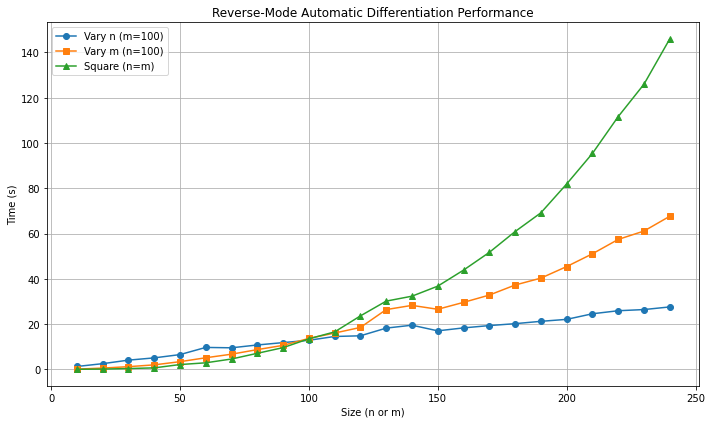

In [25]:
def vector_func(x_vars, m):
    n = len(x_vars)
    return [sum(x_vars[i] * (j+1) for i in range(n)) for j in range(m)]

def compute_jacobian_reverse(f, x_vals, m):
    n = len(x_vals)
    J = []
    for j in range(m):
        inputs = [VariableReverse(v) for v in x_vals]
        y = f(inputs, m)
        # backward only in the j-th output
        y[j].backward(1.0)
        J.append([v.adjoint for v in inputs])
    return J

def compute_jacobian(n, m):
    x_vals = np.random.rand(n).tolist()
    t0 = time.time()
    J = compute_jacobian_reverse(vector_func, x_vals, m)
    elapsed = time.time() - t0
    return elapsed, J

sizes = list(range(10, 250, 10))
fixed_m, fixed_n = 100, 100

times_vary_n_reverse = []
times_vary_m_reverse = []
times_square_reverse = []
for s in sizes:
    t1, _ = compute_jacobian(s, fixed_m)  # vary n
    t2, _ = compute_jacobian(fixed_n, s)  # vary m
    t3, _ = compute_jacobian(s, s)        # square
    times_vary_n_reverse.append(t1)
    times_vary_m_reverse.append(t2)
    times_square_reverse.append(t3)
    print(f"size={s:3d}, vary n: {t1:.4f}s, vary m: {t2:.4f}s, square: {t3:.4f}s")

# Plot results
plt.figure(figsize=(10,6))
plt.plot(sizes, times_vary_n_reverse, marker='o', label=f"Vary n (m={fixed_m})")
plt.plot(sizes, times_vary_m_reverse, marker='s', label=f"Vary m (n={fixed_n})")
plt.plot(sizes, times_square_reverse, marker='^', label="Square (n=m)")
plt.xlabel("Size (n or m)")
plt.ylabel("Time (s)")
plt.title("Reverse-Mode Automatic Differentiation Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Example 4: Benchmarking BAM Energy Function with Reverse-Mode Automatic Differentiation

In this example, we continue working with the **BAM energy function** introduced previously.

---

## BAM Energy Function

The energy function is given by:

$$
E = - \sum_{j=1}^{J} \sum_{k=1}^{K} w_{kj} x_k y_j + \sum_{k=1}^{K} \theta_k x_k + \sum_{j=1}^{J} \eta_j y_j
$$

with inputs:

$$
\text{inputs} = (x_1, \dots, x_K, y_1, \dots, y_J) \quad \in \quad \mathbb{R}^{K+J}
$$

and corresponding Jacobian:

$$
\text{Jacobian} = \left[
\frac{\partial E}{\partial x_1}, \dots, \frac{\partial E}{\partial x_K}, 
\frac{\partial E}{\partial y_1}, \dots, \frac{\partial E}{\partial y_J}
\right]
\quad \in \quad \mathbb{R}^{1 \times (K+J)}
$$

---

## Goal of the Benchmark

We aim to **measure the performance** of **reverse-mode automatic differentiation** when computing the gradient of the BAM energy function.

For varying network sizes (increasing $K$ and $J$), we benchmark:

- **Time taken** to compute the scalar energy $E(x, y)$
- **Time taken** to compute the **full gradient** (Jacobian) of $E$ with respect to all inputs
- **How performance scales** with increasing problem size

---

## Why Reverse Mode?

Since the BAM energy function is a **scalar-valued function** of many inputs, **reverse mode** is generally more efficient than forward mode for computing the full gradient, especially as the number of inputs grows.

n=10, Time=0.00100s, Energy=-0.829, Gradient dE/dx = ['-3.012', '-0.173', '2.009', '2.074', '3.325', '-2.164', '-3.139', '0.477', '-3.646', '1.873'], Gradient dE/dy = ['-3.749', '3.755', '-0.670', '-1.370', '1.398', '-1.890', '3.253', '-1.910', '0.740', '3.043']
n=20, Time=0.00399s, Energy=-0.277, Gradient dE/dx = ['0.088', '4.009', '-0.703', '-1.289', '2.018', '-2.118', '0.358', '-1.782', '-4.370', '-0.517', '-3.882', '3.973', '-0.397', '1.992', '-1.763', '0.725', '1.832', '-3.920', '-2.622', '0.480'], Gradient dE/dy = ['-0.367', '-0.709', '-0.309', '2.852', '2.508', '-2.168', '-1.922', '3.382', '-0.101', '-2.772', '-3.393', '-1.835', '0.122', '0.248', '5.355', '1.899', '-1.786', '0.431', '-1.943', '-3.537']
n=30, Time=0.00798s, Energy=18.503, Gradient dE/dx = ['2.014', '-5.228', '4.906', '-1.142', '1.168', '1.919', '2.729', '-1.154', '-3.190', '-5.775', '0.587', '-1.397', '1.426', '-5.735', '0.743', '-2.633', '-1.422', '-1.215', '2.919', '5.087', '-2.065', '0.093', '-1.948', '-2.396'

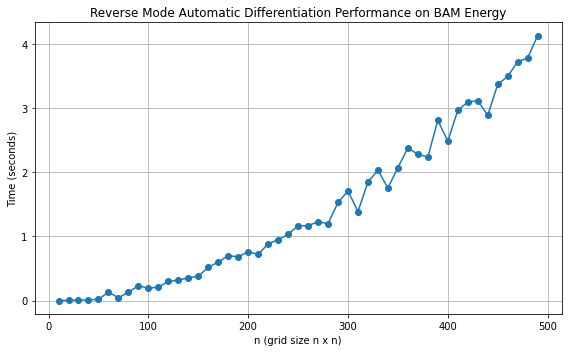

In [68]:
def bam_energy_rev(x, y, W, theta, eta):
    E = VariableReverse(0.0)
    n = len(x)
    # interaction term
    for j in range(n):
        for k in range(n):
            E = E + (-W[k][j] * x[k] * y[j])
    # theta term
    for k in range(n):
        E = E + (theta[k] * x[k])
    # eta term
    for j in range(n):
        E = E + (eta[j] * y[j])
    return E

def generate_bam_params(n):
    W = [[random.uniform(-1.0, 1.0) for _ in range(n)] for _ in range(n)]
    theta = [random.uniform(-0.5, 0.5) for _ in range(n)]
    eta = [random.uniform(-0.5, 0.5) for _ in range(n)]
    return W, theta, eta

def benchmark_bam_reverse(n):
    W, theta, eta = generate_bam_params(n)
    start = time.time()
    input_vars = [VariableReverse(random.choice([-1.0, 1.0])) for _ in range(2*n)]
    x = input_vars[:n]
    y = input_vars[n:]
    E = bam_energy_rev(x, y, W, theta, eta)
    E.backward(1.0) 
    GradientX = [x_i.adjoint for x_i in x]
    GradientY = [y_i.adjoint for y_i in y]
    elapsed = time.time() - start
    return elapsed, E.primal, GradientX, GradientY

ns = list(range(10, 500, 10))
times_reverse = []
for n in ns:
    t, energy, gradX, gradY = benchmark_bam_reverse(n)
    print(f"n={n}, Time={t:.5f}s, Energy={energy:.3f}, Gradient dE/dx = {[f'{g:.3f}' for g in gradX]}, Gradient dE/dy = {[f'{g:.3f}' for g in gradY]}")
    times_reverse.append(t)

plt.figure(figsize=(8,5))
plt.plot(ns, times_reverse, marker='o')
plt.title("Reverse Mode Automatic Differentiation Performance on BAM Energy")
plt.xlabel("n (grid size n x n)")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Forward Mode vs Reverse Mode

## Example 3: Comparing Forward and Reverse Mode on Vector Function Jacobians

In this section, we benchmark and directly compare the performance of **forward-mode** and **reverse-mode** automatic differentiation when computing the **full Jacobian** of a simple vector function.

---

## Benchmark Setup

We consider a simple vector-valued function:

$$
f: \mathbb{R}^n \to \mathbb{R}^m
$$

where each output component is given by:

$$
f(x)_j = \sum_{i=0}^{n-1} (j+1) \cdot x_i \quad \text{for} \quad j = 0, 1, \dots, m-1
$$

The Jacobian of $f$ is an $m \times n$ matrix, where each entry represents $\frac{\partial f_j}{\partial x_i}$.

We benchmark three scenarios:

- **Varying the number of inputs** $n$ while keeping outputs $m$ fixed
- **Varying the number of outputs** $m$ while keeping inputs $n$ fixed
- **Square case** where $n = m$

For each setting, we measure:

- **Time to compute the full Jacobian matrix**
- **How performance scales** with problem size

C:\Users\isidr\AppData\Local\Temp\ipykernel_23108\1065465387.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


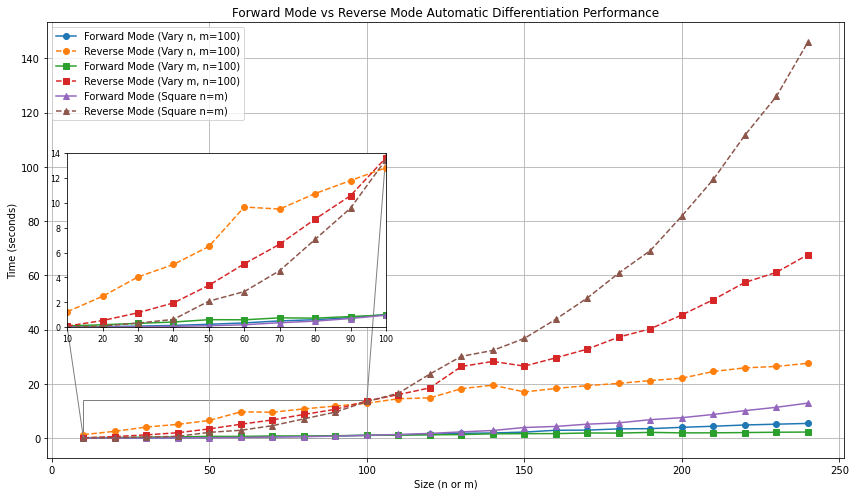

In [ ]:
# Forward-mode vs Reverse-mode
plt.figure(figsize=(12, 7))
ax = plt.gca()
# Vary n (fix m)
plt.plot(sizes, times_vary_n_forward, label="Forward Mode (Vary n, m=100)", marker='o', linestyle='-')
plt.plot(sizes, times_vary_n_reverse, label="Reverse Mode (Vary n, m=100)", marker='o', linestyle='--')

# Vary m (fix n)
plt.plot(sizes, times_vary_m_forward, label="Forward Mode (Vary m, n=100)", marker='s', linestyle='-')
plt.plot(sizes, times_vary_m_reverse, label="Reverse Mode (Vary m, n=100)", marker='s', linestyle='--')

# Square case (n = m)
plt.plot(sizes, times_square_forward, label="Forward Mode (Square n=m)", marker='^', linestyle='-')
plt.plot(sizes, times_square_reverse, label="Reverse Mode (Square n=m)", marker='^', linestyle='--')

plt.title("Forward Mode vs Reverse Mode Automatic Differentiation Performance")
plt.xlabel("Size (n or m)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)

axins = inset_axes(ax, width="40%", height="40%", loc='center left', borderpad=2)

# Mismo gráfico en la zona ampliada
axins.plot(sizes, times_vary_n_forward, marker='o', linestyle='-')
axins.plot(sizes, times_vary_n_reverse, marker='o', linestyle='--')
axins.plot(sizes, times_vary_m_forward, marker='s', linestyle='-')
axins.plot(sizes, times_vary_m_reverse, marker='s', linestyle='--')
axins.plot(sizes, times_square_forward, marker='^', linestyle='-')
axins.plot(sizes, times_square_reverse, marker='^', linestyle='--')

# Zona de interés para el zoom
axins.set_xlim(10, 100)   # Zoom en el eje x: tamaños pequeños
axins.set_ylim(0, 14)    # Zoom en eje y: hasta 20 segundos

# Opcional: mostrar ejes internos para claridad
axins.tick_params(labelsize=8)

# Conecta visualmente la región ampliada
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.tight_layout()
plt.show()

## Results

We plot the computation time for both **forward-mode** and **reverse-mode** automatic differentiation on the same graphs for direct visual comparison.

- In **forward-mode**, each input direction is processed separately.
- In **reverse-mode**, each output is backpropagated separately.

---

## Observations

- Forward-mode is particularly efficient because it computes derivatives with respect to each input independently.
- Reverse-mode would be more advantageous if the number of **outputs** ($m$) were much smaller than the number of inputs, but here each output depends similarly on all inputs, and the overhead of reverse-mode accumulates.
- In the **square case** ($n = m$), forward-mode still remains faster at moderate sizes.



## Example 4: Comparing Forward and Reverse Mode on BAM Energy Function

In this section, we benchmark and directly compare the performance of **forward-mode** and **reverse-mode** automatic differentiation when computing gradients of the **BAM energy function**.

---

## Benchmark Setup  

We use the same BAM energy function defined earlier:

$$
E = - \sum_{j=1}^{n} \sum_{k=1}^{n} w_{kj} x_k y_j + \sum_{k=1}^{n} \theta_k x_k + \sum_{j=1}^{n} \eta_j y_j
$$

where the input consists of the concatenated vector of all $x$ and $y$ variables, each taking values in $\{-1, 1\}$.  
The parameters $W$, $\theta$, and $\eta$ are randomly generated for each run.

The performance is evaluated by measuring:

- **Total time** to compute the energy $E$ and the **full gradient** (with respect to all input variables)
- **How computation time scales** as the network size $n$ increases

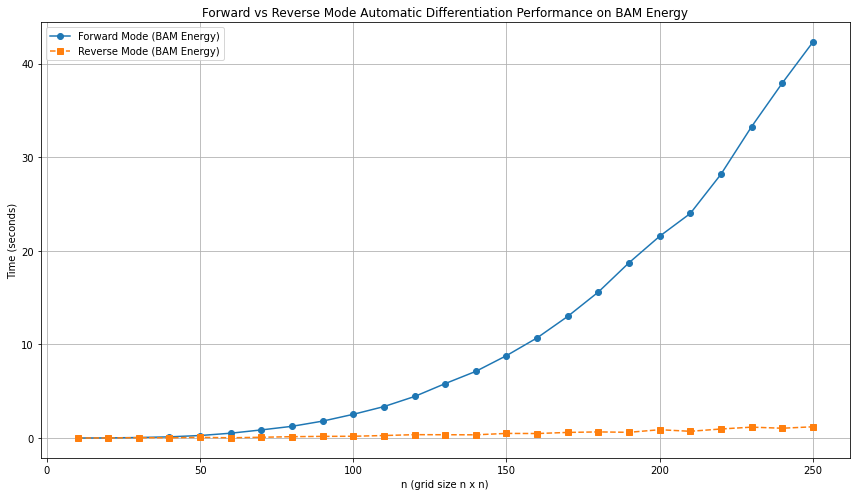

In [ ]:
# Forward-mode vs Reverse-mode on BAM Energy

plt.figure(figsize=(12, 7))

min_len = min(len(times_forward), len(times_reverse))
ns_common = ns[:min_len]

# Plotting
plt.plot(ns_common, times_forward[:min_len], label="Forward Mode (BAM Energy)", marker='o', linestyle='-')
plt.plot(ns_common, times_reverse[:min_len], label="Reverse Mode (BAM Energy)", marker='s', linestyle='--')

plt.title("Forward vs Reverse Mode Automatic Differentiation Performance on BAM Energy")
plt.xlabel("Epoch (n)")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Results

We plot the time taken by **forward-mode** and **reverse-mode** on the same graph for direct comparison.

- **Forward-mode** computes each partial derivative separately, looping over all inputs
- **Reverse-mode** computes the gradient in a single backward pass

---

## Observations

- For small $n$, both modes perform similarly.
- As $n$ grows larger, **reverse-mode** becomes significantly more efficient, especially because the BAM energy is a **scalar-valued function** of many inputs.
- The benchmark clearly illustrates that **reverse-mode scales better** for functions where the output dimension is much smaller than the input dimension.